In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
import cv2


In [4]:
cd /content/drive/MyDrive/Deep Learning/Image Segmentation

/content/drive/MyDrive/Deep Learning/Image Segmentation


In [32]:
!unzip cityscapes_data.zip


Archive:  cityscapes_data.zip
replace cityscapes_data/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
train_dir = "/content/drive/MyDrive/Deep Learning/Image Segmentation/cityscapes_data"


In [6]:
fnames = [os.path.join(train_dir,fname) for fname in os.listdir(train_dir)]

In [7]:
train_data = [cv2.imread(i) for i in fnames]


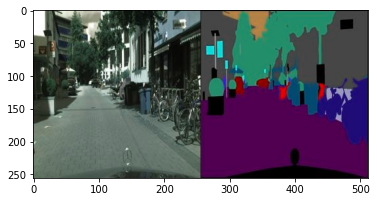

In [8]:
plt.imshow(train_data[3])

In [9]:
train_data[0].shape

(256, 512, 3)

In [11]:
X_train = []
Y_train = []


In [29]:
label = np.array([[142,0,0],  #car
    [180,130,70], #sky
    [127,64,128],  #road
    [35,142,107] 
    ]) #tree


In [12]:
for i in train_data:
  img1 = i[:,:256,:]
  img2 = i[:,256:,:]
  X_train.append(img1)
  Y_train.append(img2) 


In [13]:
x_train = [cv2.resize(i,(128,128)) for i in X_train]
y_train = [cv2.resize(i,(128,128)) for i in Y_train]

In [14]:
x_train[0].shape,y_train[0].shape

((128, 128, 3), (128, 128, 3))

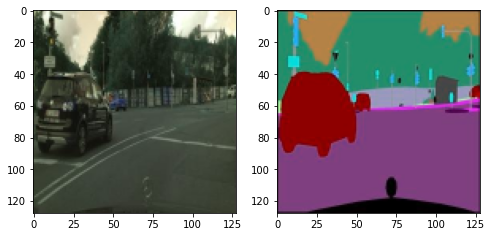

In [15]:
fig = plt.figure(figsize =(8,4))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(y_train[0])

In [43]:
y_train1 = []

In [85]:
x_train[0].shape

(128, 128, 3)

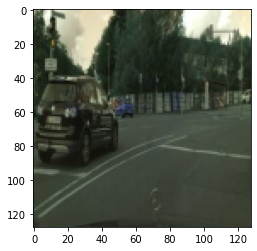

In [84]:
plt.imshow(x_train[0])

In [31]:
i = y_train[0]
i.shape

(128, 128, 3)

In [34]:
for row in range(i.shape[0]):
   for col in range(i.shape[1]):
      a = i[row,col,:]
      print(a.shape)
      break
   break

(3,)


In [44]:
for i in y_train:
  mask = np.zeros(shape=(128,128))
  for row in range(i.shape[0]):
   for col in range(i.shape[1]):
      a = i[row,col,:].reshape((1,1,3))   
      distances = np.min(np.linalg.norm(a - label, axis=2),axis = 0)
      d = min(distances)
      key = distances.argmin()
      mask[row,col] = key
  y_train1.append(mask)

In [48]:
y_train = np.array(y_train1)

In [49]:
y_train.shape

(2975, 128, 128)

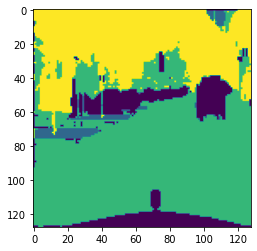

In [54]:
plt.imshow(y_train[2])

In [57]:
np.unique(y_train[0])

array([0., 1., 2., 3.])

In [59]:
x_train = np.array(x_train)

In [60]:
x_train.shape,y_train.shape

((2975, 128, 128, 3), (2975, 128, 128))

In [63]:
import tensorflow as tf

In [66]:
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Dropout,UpSampling2D,Concatenate

In [81]:
def get_unet_model():
  inputs = tf.keras.layers.Input(shape = [128,128,3])

  f1 = Conv2D(64,kernel_size = (3,3),padding = 'same', strides =1 , activation = 'relu')(inputs)
  b1 = BatchNormalization()(f1)
  f2 = Conv2D(64,kernel_size = (3,3), padding ='same', strides = 1, activation ='relu')(b1)
  m3 = MaxPooling2D(pool_size = (2,2), strides = 2)(f2)
  d4 = Dropout(0.2)(m3)

  f5 = Conv2D(128,kernel_size = (3,3), padding ='same',strides = 1, activation = 'relu')(d4)
  b5 = BatchNormalization()(f5)
  f6 = Conv2D(128,kernel_size = (3,3),padding = 'same',strides = 1 ,activation ='relu')(b5)
  m7 = MaxPooling2D(pool_size = (2,2),strides = 2)(f6)
  d8 = Dropout(0.2)(m7)
  f9 = Conv2D(256,kernel_size = (3,3),padding = 'same',strides = 1,activation = 'relu')(d8)
  b9 = BatchNormalization()(f9)
  f10 = Conv2D(256,kernel_size=(3,3), padding='same',strides = 1,activation = 'relu')(b9)
  m11 = MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
  d12 = Dropout(0.2)(m11)
    
    #Forth Downsample
  f13 =Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
  b13 = BatchNormalization()(f13)
  f14 = Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection
    
  m15 =MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
  d16 = Dropout(0.2)(m15)
    
    #Fifth Downsample
  f17 = Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
  b17 = BatchNormalization()(f17)
  f18 = Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)

    
    # First Upsample
  m19 = UpSampling2D(size = (2, 2))(f18)
  d19 =Dropout(0.2)(m19)
  c20 = tf.keras.layers.Concatenate()([d19, f14])
  f21 = Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
  b21 = BatchNormalization()(f21)
  f22 = Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)
    
    # Second Upsample
  m23 = UpSampling2D(size = (2, 2))(f22)
  d23 = Dropout(0.2)(m23)
  c24 = tf.keras.layers.Concatenate()([d23, f10])
  f25 = Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
  b25 = BatchNormalization()(f25)
  f26 = Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)
    
    # Third Upsample
  m27 = UpSampling2D(size = (2, 2))(f26)
  d27 = Dropout(0.2)(m27)
  c28 = Concatenate()([d27, f6])
  f29 = Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
  b29 = BatchNormalization()(f29)
  f30 = Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)
    
    #Forth Upsample
  m31 = UpSampling2D(size = (2, 2))(f30)
  d31 = Dropout(0.2)(m31)
  c32 = tf.keras.layers.Concatenate()([d31, f2])
  f33 = Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
  b33 = BatchNormalization()(f33)
  f34 = Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)
    
    # Output Layer
  outputs =Conv2D(4, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)
    
  model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
  return model

In [82]:
model = get_unet_model()

In [83]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [75]:
X_train = x_train[:2500,:,:,:]
X_test = x_train[2500:,:,:,:]
Y_train = y_train[:2500,:,:]
Y_test = y_train[2500:,:,:]

In [77]:
X_train.shape

(2500, 128, 128, 3)

In [78]:
Y_train.shape

(2500, 128, 128)

In [84]:
history = model.fit(X_train,Y_train, epochs = 5, batch_size = 32)

Epoch 1/5
79/79 [==============================] - 53s 579ms/step - loss: 0.5402 - accuracy: 0.7927
Epoch 2/5
79/79 [==============================] - 41s 515ms/step - loss: 0.3950 - accuracy: 0.8536
Epoch 3/5
79/79 [==============================] - 41s 519ms/step - loss: 0.3544 - accuracy: 0.8717
Epoch 4/5
79/79 [==============================] - 41s 517ms/step - loss: 0.3249 - accuracy: 0.8843
Epoch 5/5
79/79 [==============================] - 41s 520ms/step - loss: 0.3062 - accuracy: 0.8910


In [86]:
model.save("Unet.h5")

In [89]:
save_model = tf.keras.models.load_model("Unet.h5")

In [95]:
X_test[1:2].shape

(1, 128, 128, 3)

In [110]:
result = save_model.predict(X_test[1:2])

1/1 [==============================] - 0s 22ms/step


In [117]:
result = result.reshape(128,128,4)

In [118]:
final = np.zeros((128,128))

In [119]:
result.shape

(128, 128, 4)

In [115]:
result[0,0,0,:]

array([8.9938021e-01, 4.6479914e-04, 5.2742353e-03, 9.4880782e-02],
      dtype=float32)

In [120]:
for row in range(result.shape[0]):
  for col in range(result.shape[1]):
    final[row][col] = np.argmax(result[row,col,:])


In [121]:
np.unique(final)

array([0., 1., 2., 3.])

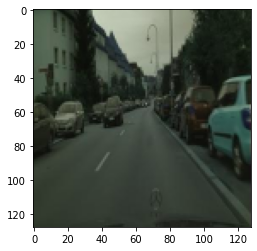

In [124]:
plt.imshow(X_test[1])

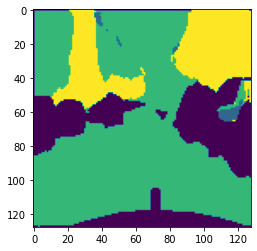

In [122]:
plt.imshow(final)

In [102]:
final

61668